In [1]:
import numpy as np
import torch
from epiweeks import Week
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
from online_training import get_params
from utils import pickle_load

/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
from utils import decode_onehot
a = torch.Tensor([[1, 0, 0], [2, 3, 0], [3, 4, 5]])
new_a = torch.zeros((a.size()[0]))
for i in range(a.size()[0]):
    idx = torch.max(torch.nonzero(a[i]))
    new_a[i] = a[i, idx]
print(new_a)
# print(decode_onehot(a))

tensor([1., 3., 5.])


In [26]:

rft_res = pickle_load('../../results/base_pred/saved_pred_999.pickle')
for preds in rft_res['base_pred']:
    print(preds[1]['AL'][1].shape)
    break

(4,)


In [27]:
baseline_res = pickle_load('../../results/base_pred/saved_pred_20234300.pickle', True)
for preds in baseline_res['base_pred']:
    print(preds[1]['AL'][1].shape)
    break

(5,)


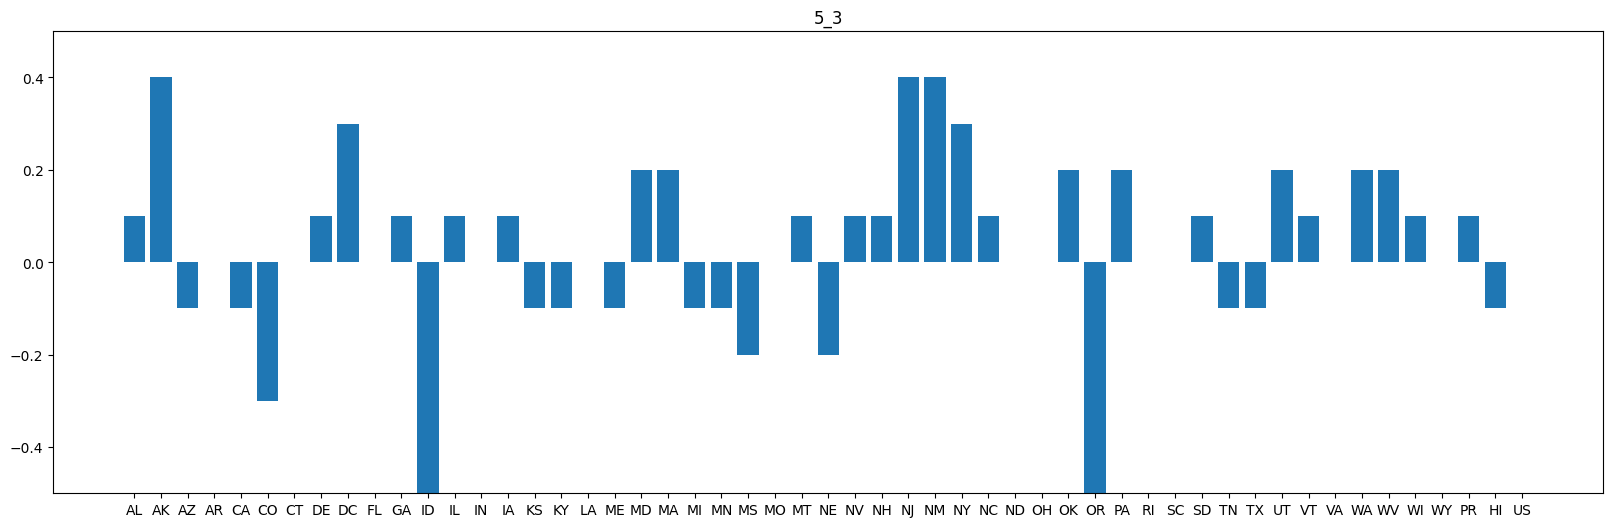

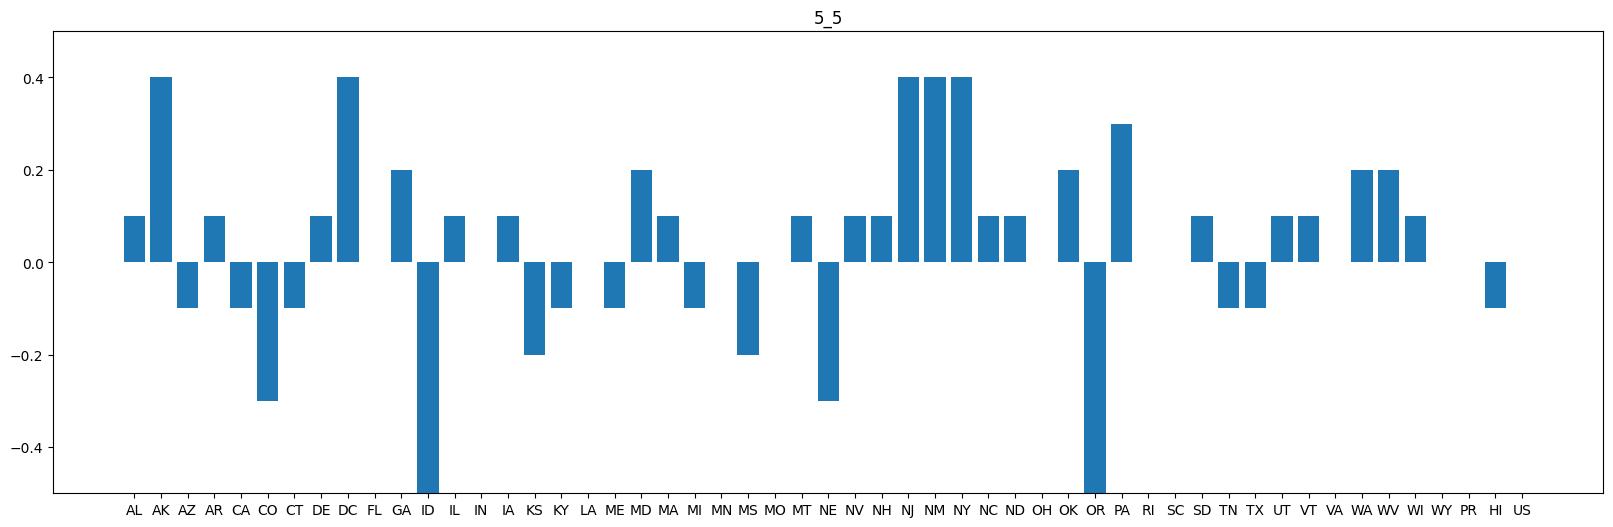

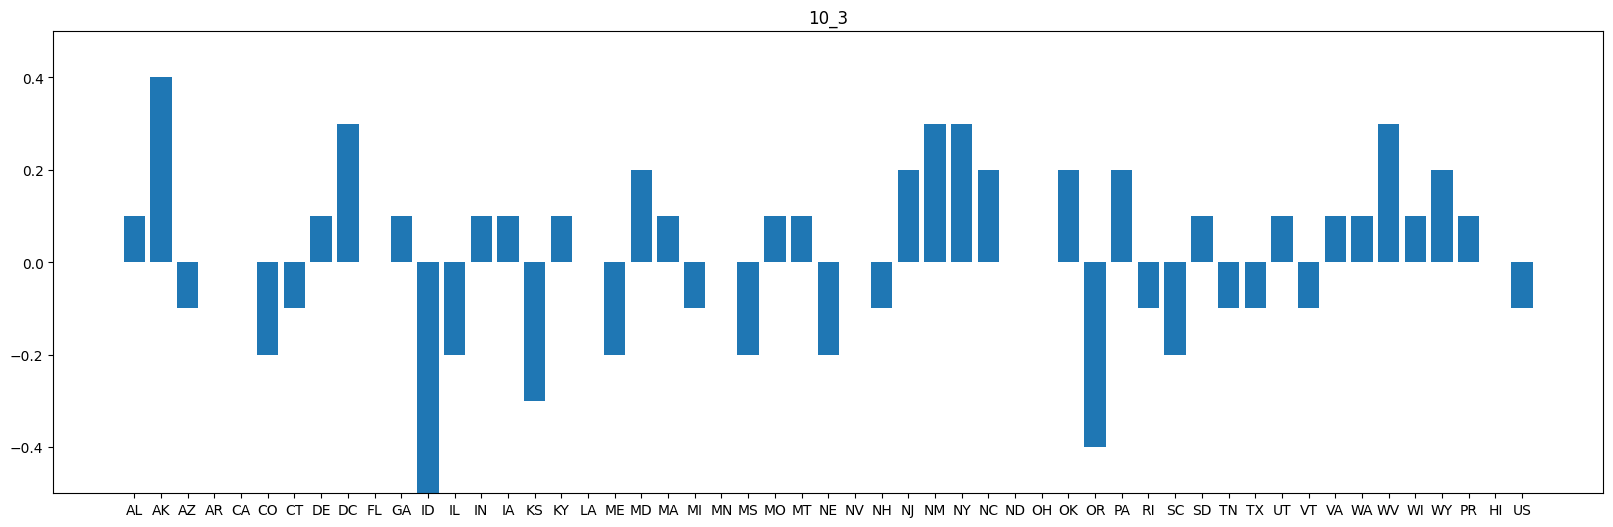

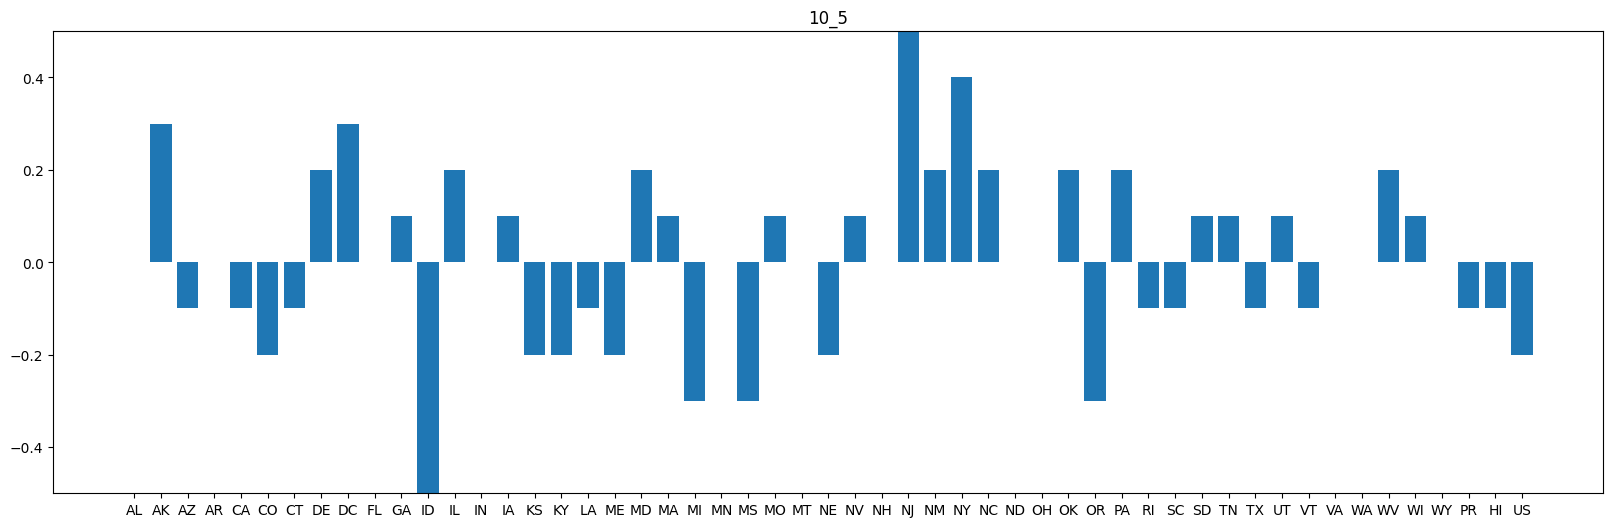

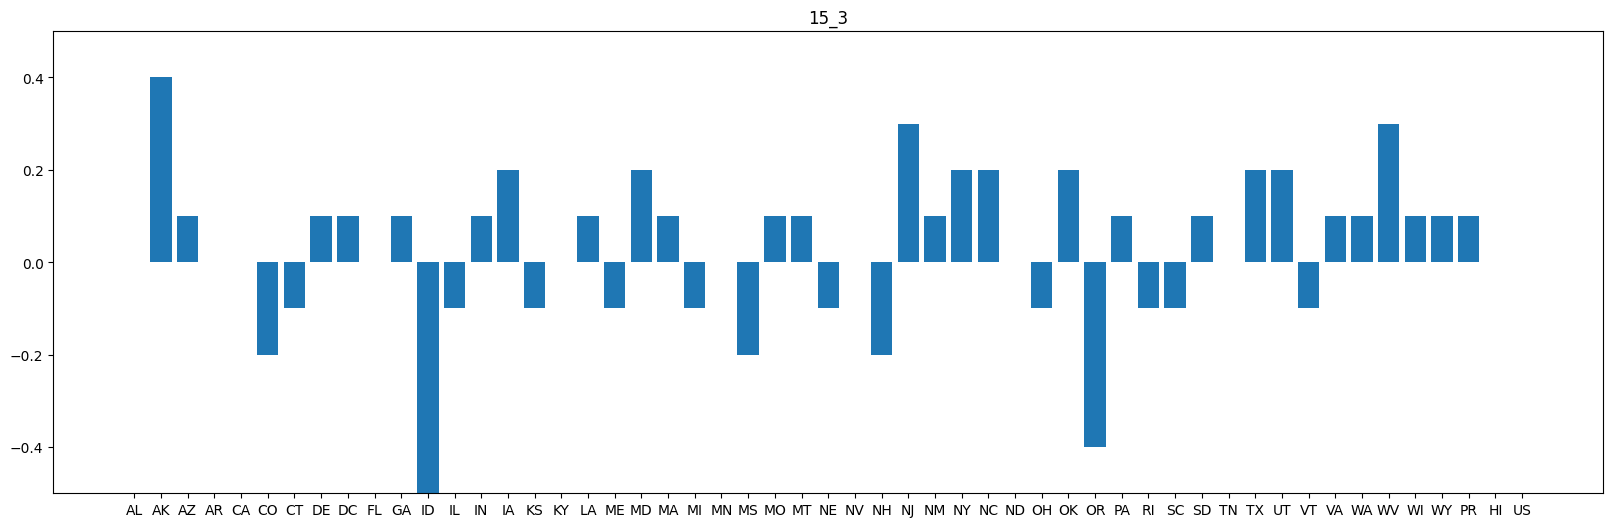

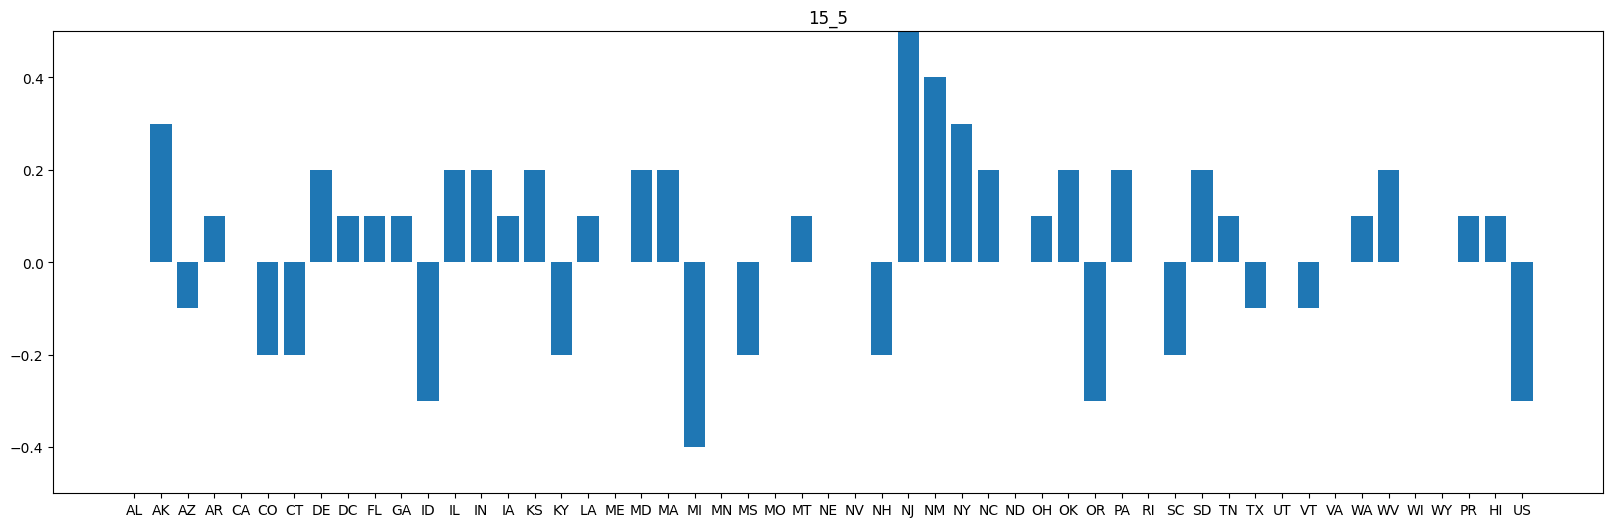

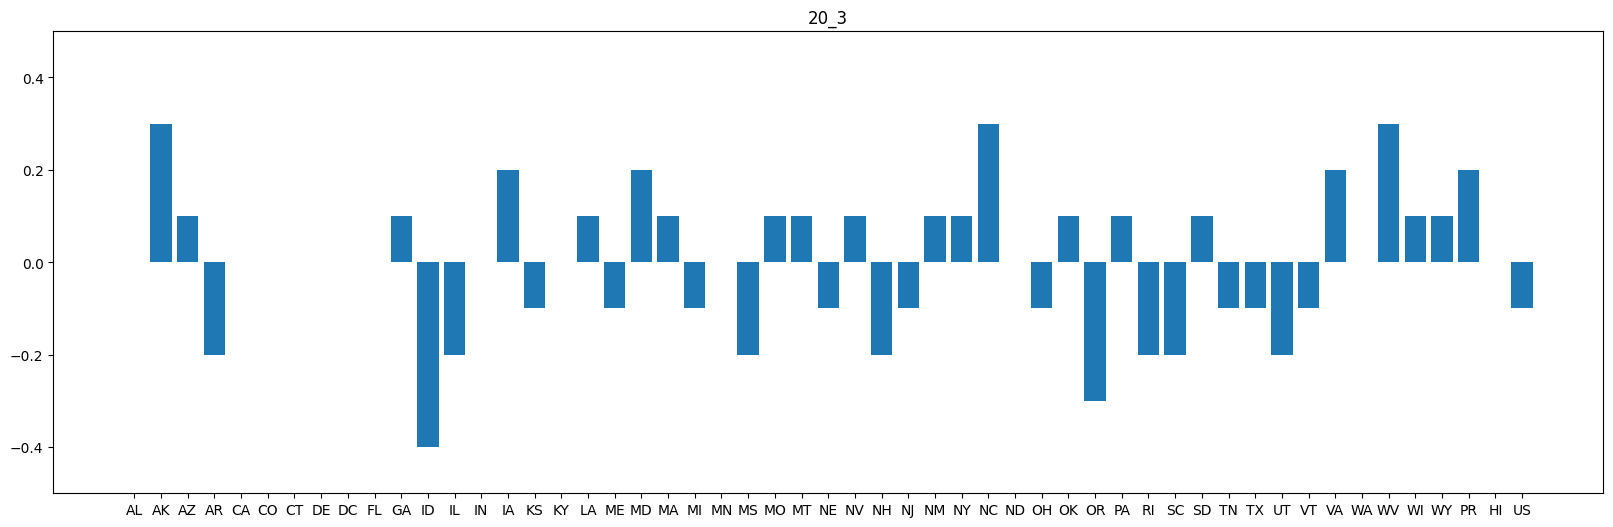

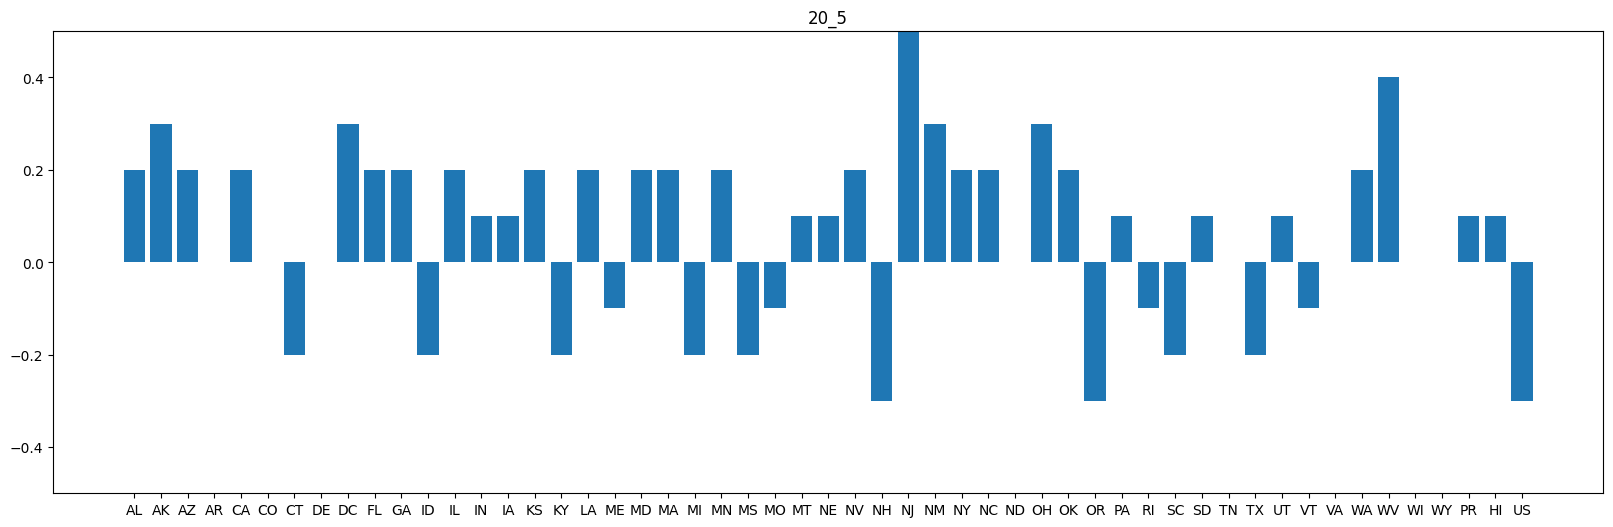

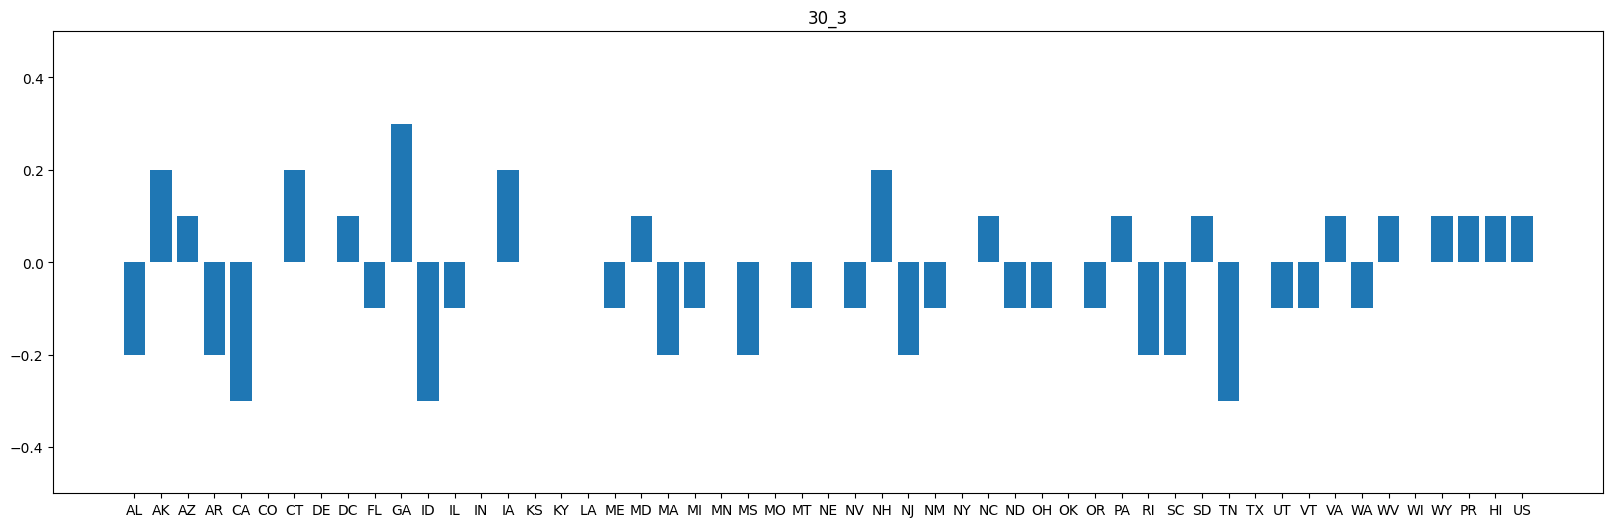

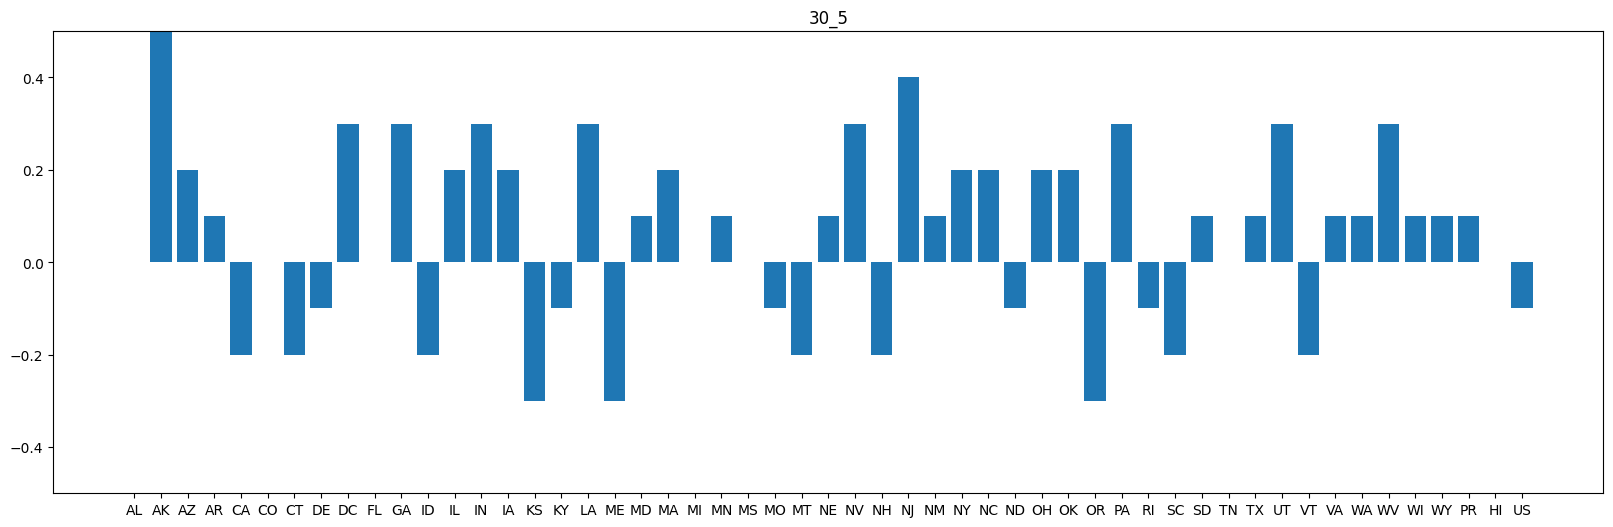

In [13]:
# scale_factors = [0.5, 1, 1.5, 2, 2.5, 3]
# err_windows = [4, 6, 10, 12, 15]
scale_factors = [0.5, 1, 1.5, 3]
err_windows = [3]
q_idx = 0
aheadidx = 0

for scale_factor in scale_factors:
    for err_window in err_windows:
        try:
            fname = f'../../results/erri/{int(scale_factor*10)}_{err_window}.pkl'
            all_results = pickle_load(fname)
            q0_res = all_results[q_idx]
            x_ticks = []
            y_values = []
            for region in q0_res:
                x_ticks.append(region)
                y_values.append(q0_res[region][aheadidx])
                # print(q0_res[region][0])
            plt.figure(figsize=(20,6))
            plt.bar(x_ticks, y_values)
            plt.ylim(-0.5, 0.5)
            plt.title(f'{int(scale_factor*10)}_{err_window}')
            plt.show()
        except:
            print(f'{scale_factor}, {err_window} not available yet.')

In [ ]:
def err2quantile(err):
    # out = 0
    # if abs(err) < 0.1:
    #     return 0
    # if abs(err) < 0.15:
    #     return err * 2
    # return err * 4
    sign = 1 if err > 0 else -1
    scaled_err = min(abs(err) * 3, 0.9)
    out = np.tan(scaled_err) * sign
    return out
xs = [(i-100)/100 for i in range(200)]
ys = [err2quantile(x) for x in xs]
plt.plot(xs, ys)

In [ ]:
base_pred = pickle_load('../../results/base_pred/saved_pred_20234301.pickle', True)
for key, value in base_pred['params'].items():
    print(key, value)

In [ ]:
params = get_params()

In [ ]:
def load_df(data_file, region, start_week_data, pred_week, shift=False):
    """ load data and subset to desired region and epiweeks"""
    def convert_to_epiweek(x):
        """ convert string of the format YYYYww to epiweek object """
        return Week.fromstring(str(x))
    # load and clean data
    df = pd.read_csv(data_file, low_memory=False)
    df = df[(df["region"] == region)]
    
    df['epiweek'] = df.loc[:, 'epiweek'].apply(convert_to_epiweek)
    df = df[(df["epiweek"] <= pred_week) & (df["epiweek"] >= start_week_data)]
    # subset data using init parameters
    if shift:
        columns_to_shift = df.columns[6:19]
        df[columns_to_shift] = df.groupby('region')[columns_to_shift].shift(periods=-1)
        df = df.groupby('region').apply(lambda group: group.iloc[:-2] if len(group) >= 2 else group).reset_index(drop=True)
    # df = df.fillna(method="ffill")
    # df = df.fillna(method="backfill")
    df = df.fillna(0)

    # return subset of data
    return df[params['data_features'] + ['flu_hospitalizations', 'epiweek']]

In [ ]:
data_file = '../../data/weekly/weeklydata/202341.csv'
start_week_data = Week.fromstring('202052')
pred_week = Week.fromstring('202341')

df1 = load_df(data_file, 'US', start_week_data, pred_week, shift=True)
df2 = load_df(data_file, 'US', start_week_data, pred_week, shift=False)
df3 = load_df(data_file, 'US', start_week_data, pred_week-2, shift=True)

In [ ]:
df1

In [ ]:
df3

In [ ]:
from utils import pickle_load

saved_pred1 = pickle_load('../../results/base_pred/saved_pred_3.pickle')
base_pred = saved_pred1['base_pred']
test_pred = saved_pred1['test_pred']
for i in range(len(base_pred)):
    pred, addi = base_pred[i]
    _, y_true, _ = addi['AK']
    print(y_true)

In [ ]:
from data_utils import epiweek_sub

week1 = Week.fromstring('202101')
week2 = Week.fromstring('202109')
print(epiweek_sub(week2, week1))

In [ ]:
def viz_hpst():
    hpst_params = None
    with open('../../setup/hpst.yaml', 'r') as stream:
        try:
            hpst_params = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print('Error in reading parameters file')
            print(exc)
    hps = hpst_params['hps']
    for key0 in hps:
        print(f'###{key0}###')
        for key1 in hps[key0]:
            print(f'{key1}: {res["params"][key0][key1]}')

In [ ]:
hpst_params = None
with open('../../setup/hpst.yaml', 'r') as stream:
    try:
        hpst_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print('Error in reading parameters file')
        print(exc)
hps = hpst_params['hps']
results = pickle_load('../../results/hpst/8.pkl', version5=True)
for exp_id, res in results.items():
    print('\n')
    print(res['results']['mean_mse'])
    for key0 in hps:
        print(f'###{key0}###')
        for key1 in hps[key0]:
            print(f'{key1}: {res["params"][key0][key1]}')

In [ ]:
import random

for i in range(10):
    random.seed()
    idx = random.randint(1, 10000)
    print(idx)
    random.seed(10)


In [ ]:
import random
init_params = {
    'a': 10,
    'b': 12
}
hpst_results = {}
for i in range(4):
    current_params = init_params.copy()
    for key in init_params:
        random.seed()
        idx = random.randint(1, 10000)
        current_params[key] = idx
    hpst_results[i] = {
        'params': current_params,
    }

In [ ]:
for i in range(4):
    print(hpst_results[i]['params'])